In [ ]:
import torch
import torch.nn as nn

import utils
import data_utils
import train_utils

import models

import matplotlib.pyplot as plt

# Rotated MNIST: all rotations (tasks) flattened



## Utility functions

In [ ]:
def plot_training_loss(lc, config):
    #plt.plot(loss, marker='o')
    plt.plot(lc)

    plt.title('Training loss vs. Number of training steps')
    plt.xlabel('Number of training steps')
    plt.ylabel('Training loss')
    plt.savefig(config['model_name']+'_training-loss-vs-number-of-training-steps-rotated-MNIST-'+str(config['per_task_rotation'])+'deg.pdf')
    plt.show()

In [ ]:
# Function to train the model
def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    loss_canonical = []
    for epoch in range(num_epochs):
        print('epoch', epoch)
        model.train()
        for inputs, labels, _ in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            loss_canonical.append(loss.detach().numpy())

    return loss_canonical

# Function to evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels, _ in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

## SimpleNN model

### Warmup: training a first model (on 8 tasks with 45° per task)

In [ ]:
config = {
    # ---COMMON----
    'setting': 'AllRotationsFlattened',
    'model_name': 'SimpleNN',
    'num_tasks': 8, 'per_task_rotation': 45,
    #'trial': TRIAL_ID, 'exp_dir': EXP_DIR,\
    #'memory_size': 200, 'dataset': DATASET, 'device': DEVICE, 'momentum': 0.8,\
    #'mlp_hiddens': HIDDENS, 'dropout': 0.2, 'lr_decay': 0.8, 'stable_sgd': False,\
    'batch_size': 64,\
    'rounds': 10
}

In [ ]:
model = models.SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loader, test_loader = data_utils.create_flattened_rotated_mnist_task(config['num_tasks'], config['per_task_rotation'], config['batch_size'])

lc = train_utils.train_model(model, train_loader, criterion, optimizer, tasks_flattend=True)
accuracy = train_utils.evaluate_model(model, test_loader, tasks_flattened=True)

accuracy= 0.949


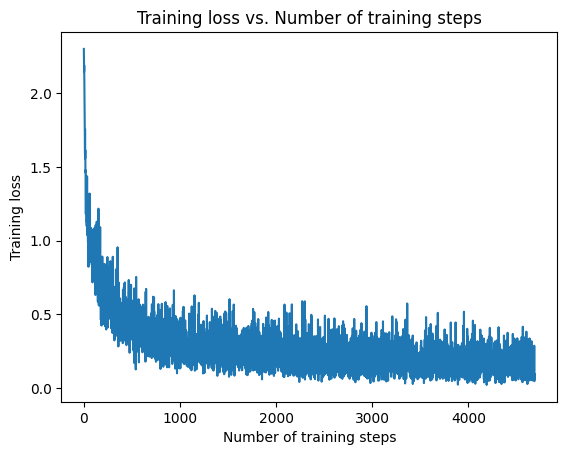

In [ ]:
print('accuracy=', accuracy)
plot_training_loss(lc, config)

#### Multiple runs

In [ ]:
train_loader, test_loader = data_utils.create_flattened_rotated_mnist_task(config['num_tasks'], config['per_task_rotation'], config['batch_size'])

In [ ]:
accs_over_runs = {} 
train_losses_over_runs = {}

rounds = config['rounds']
for seed in range(rounds):
    utils.set_seed(seed)

    print("training A NEW MODEL with Rotated MNIST all angles flattened ...")

    # Define the neural network, criterion, and optimizer
    model = models.SimpleNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_loss = train_utils.train_model(model, train_loader, criterion, optimizer, tasks_flattened=True)
    train_losses_over_runs.setdefault('all angles flattened', []).append(train_loss)

    accuracy = train_utils.evaluate_model(model, test_loader, tasks_flattened=True)
    accs_over_runs.setdefault('all angles flattened', []).append(accuracy)



Random seed set as 0
training A NEW MODEL with Rotated MNIST all angles flattened ...
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
Random seed set as 1
training A NEW MODEL with Rotated MNIST all angles flattened ...
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
Random seed set as 2
training A NEW MODEL with Rotated MNIST all angles flattened ...
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
Random seed set as 3
training A NEW MODEL with Rotated MNIST all angles flattened ...
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
Random seed set as 4
training A NEW MODEL with Rotated MNIST all angles flattened ...
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
Random seed set as 5
training A NEW MODEL with Rotated MNIST all angles flattened ...
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
Random seed set as 6
training A NEW MODEL with Rotated MNIST all angles flattened ...
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
Random seed set as 7
training A NEW MODEL with Rotated MNIST all angles flattened ...
epoch 0
epoch 1
epoch 2
epoch 3


2.3176053
0.032736022


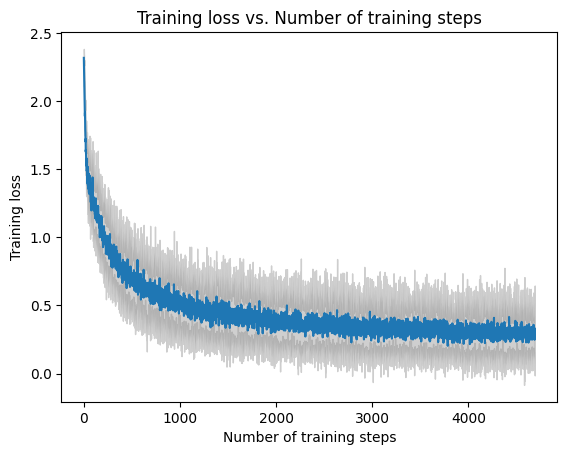

In [ ]:
plot_losses_over_runs(train_losses_over_runs, config)

In [ ]:
print(train_losses_over_runs)

In [ ]:
print(accs_over_runs)

{'all angles flattened': [0.9084, 0.9128, 0.9099, 0.9059, 0.9154, 0.9037, 0.9131, 0.9112, 0.9095, 0.9117]}


In [ ]:
filename = '{}_{}_accs_over_runs_{}_runs.json'.format(
    config['setting'],
    config['model_name'],
    config['rounds']
)
utils.save_accs(accs_over_runs, config, filename=filename)

### Accuracy vs. Number of tasks

**NB.** Distance between the first and last task is fixed to 180°

Here, we are kind of trying to evaluate how the models behave as a function of the granularity of data in the roation space from 0° to 180°

In [ ]:
def perfs_over_numtasks_multiple_runs(net, config):
    train_losses_over_numtasks_and_runs = {}
    accs_over_numtasks_and_runs = {}

    rounds = config['rounds']
    for seed in range(rounds):
        utils.set_seed(seed)

        for num_tasks in range(3, 20):
            config['num_tasks'] = num_tasks
            config['per_task_rotation'] = 180//num_tasks

            print('training a new model on ', config['num_tasks'], 'tasks')
            print('per task rotation in this situation is ', config['per_task_rotation'], 'deg')

            model = net()
            criterion = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

            train_loader, test_loader = data_utils.create_flattened_rotated_mnist_task(config['num_tasks'],
                                                                                       config['per_task_rotation'],
                                                                                       config['batch_size'])

            train_loss = train_utils.train_model(model, train_loader, criterion, optimizer, tasks_flattened=True)
            train_losses_over_numtasks_and_runs.setdefault(num_tasks, []).append(train_loss)

            accuracy = train_utils.evaluate_model(model, test_loader, tasks_flattened=True)
            accs_over_numtasks_and_runs.setdefault(num_tasks, []).append(accuracy)

    return train_losses_over_numtasks_and_runs, accs_over_numtasks_and_runs



In [ ]:
train_losses_over_numtasks_and_runs, accs_over_numtasks_and_runs = perfs_over_numtasks_multiple_runs(models.SimpleNN, config)

Random seed set as 0
training a new model on  3 tasks
per task rotation in this situation is  60 deg
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
training a new model on  4 tasks
per task rotation in this situation is  45 deg
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
training a new model on  5 tasks
per task rotation in this situation is  36 deg
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
training a new model on  6 tasks
per task rotation in this situation is  30 deg
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
training a new model on  7 tasks
per task rotation in this situation is  25 deg
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
training a new model on  8 tasks
per task rotation in this situation is  22 deg
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
training a new model on  9 tasks
per task rotation in this situation is  20 deg
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
training a new model on  10 tasks
per task rotation in this situation is  18 deg
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
training a new mod

In [ ]:
filename = '{}_{}_accs_over_numtasks_and_runs_{}_runs.json'.format(
    config['setting'],
    config['model_name'],
    config['rounds']
)
utils.save_accs(accs_over_numtasks_and_runs, config, filename=filename)

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


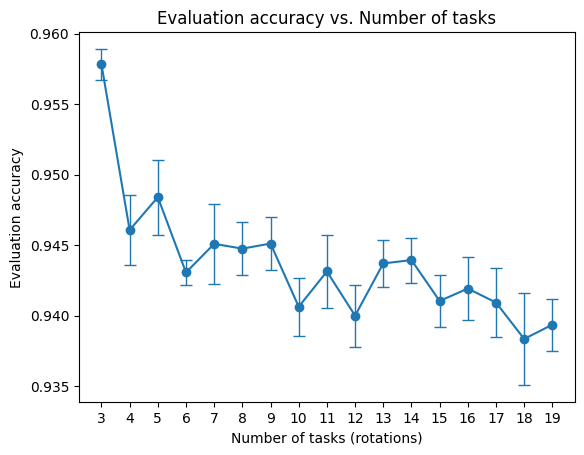

In [ ]:
plot_accuracies_mean_std(accs_over_numtasks_and_runs, config, title='Evaluation accuracy vs. Number of tasks', xlabel='Number of tasks (rotations)')

In [ ]:
plot_losses_over_runs(train_losses_over_numtasks_and_runs, config)

### Accuracy vs. Distance between tasks

**NB.** Number of tasks is fixed

In [ ]:
def perf_vs_distance_between_tasks_multiple_runs(net, config):
    train_losses_over_numtasks_and_runs = {}
    accs_over_numtasks_and_runs = {}

    config['num_tasks'] = 5
    rounds = config['rounds']
    for seed in range(rounds):
        utils.set_seed(seed)

        for per_task_rotation in range(5, 30, 5):
            config['per_task_rotation'] = per_task_rotation

            print('training a new model on ', config['num_tasks'], 'tasks, each separated by ', config['per_task_rotation'], 'degrees')

            model = net()
            criterion = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

            train_loader, test_loader = data_utils.create_flattened_rotated_mnist_task(config['num_tasks'],
                                                                                       config['per_task_rotation'],
                                                                                       config['batch_size'])

            train_loss = train_utils.train_model(model, train_loader, criterion, optimizer, tasks_flattened=True)
            train_losses_over_numtasks_and_runs.setdefault(per_task_rotation, []).append(train_loss)

            accuracy = train_utils.evaluate_model(model, test_loader, tasks_flattened=True)
            accs_over_numtasks_and_runs.setdefault(per_task_rotation, []).append(accuracy)

    return train_losses_over_numtasks_and_runs, accs_over_numtasks_and_runs



In [ ]:
train_losses_over_numtasks_and_runs, accs_over_numtasks_and_runs = perf_vs_distance_between_tasks_multiple_runs(models.SimpleNN, config)

Random seed set as 0
training a new model on  5 tasks, each separated by  5 degrees
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
training a new model on  5 tasks, each separated by  10 degrees
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
training a new model on  5 tasks, each separated by  15 degrees
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
training a new model on  5 tasks, each separated by  20 degrees
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
training a new model on  5 tasks, each separated by  25 degrees
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
Random seed set as 1
training a new model on  5 tasks, each separated by  5 degrees
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
training a new model on  5 tasks, each separated by  10 degrees
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
training a new model on  5 tasks, each separated by  15 degrees
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
training a new model on  5 tasks, each separated by  20 degrees
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
training a new model on 

In [ ]:
filename = '{}_{}_accs_over_distancebetweentasks_and_runs_{}_runs.json'.format(
    config['setting'],
    config['model_name'],
    config['rounds']
)
utils.save_accs(accs_over_numtasks_and_runs, config, filename=filename)

['5', '10', '15', '20', '25']


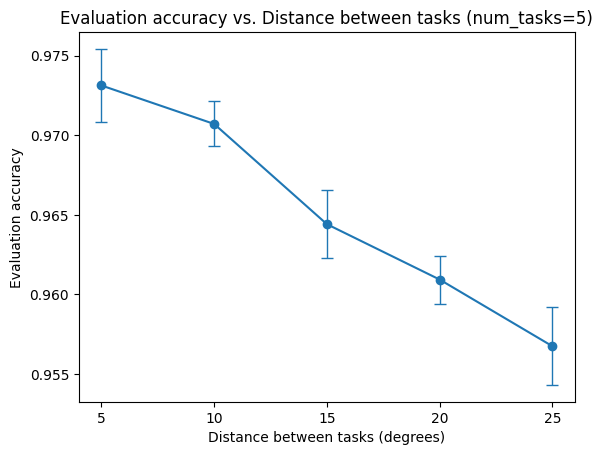

In [ ]:
plot_accuracies_mean_std(accs_over_numtasks_and_runs, config, title='Evaluation accuracy vs. Distance between tasks (num_tasks=5)', xlabel='Distance between tasks (degrees)')

## e2cnn model

### Warmup: training a first model (on 8 tasks with 45° per task)

**NB** # the model (C8SteerableCNN) is equivariant under rotations by 45 degrees, modelled by C8

In [ ]:
config = {
    # ---COMMON----
    'model_name': 'C8SteerableCNN',
    'num_tasks': 8, 'per_task_rotation': 45, 'trial': TRIAL_ID, 'exp_dir': EXP_DIR,\
    'memory_size': 200, 'dataset': DATASET, 'device': DEVICE, 'momentum': 0.8,\
    'mlp_hiddens': HIDDENS, 'dropout': 0.2, 'lr_decay': 0.8, 'stable_sgd': False,\
    'batch_size': 64
}

In [ ]:
#--------------------------------------------
'''
These transformations are required according to the notebook where
C8SteerableCNN come from: https://github.com/QUVA-Lab/e2cnn/blob/master/examples/model.ipynb

**NB** this is the code that has been used to train C8SteerableCNN
train_transform = Compose([
    pad,
    resize1,
    RandomRotation(180, interpolation=Image.BILINEAR, expand=False),
    resize2,
    totensor,
])

mnist_train = MnistRotDataset(mode='train', transform=train_transform)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64)


test_transform = Compose([
    pad,
    totensor,
])
mnist_test = MnistRotDataset(mode='test', transform=test_transform)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-5)
'''
from torchvision.transforms import Pad
from torchvision.transforms import Resize
from torchvision.transforms import Compose

# images are padded to have shape 29x29.
# this allows to use odd-size filters with stride 2 when downsampling a feature map in the model
pad = Pad((0, 0, 1, 1), fill=0)

# to reduce interpolation artifacts (e.g. when testing the model on rotated images),
# we upsample an image by a factor of 3, rotate it and finally downsample it again
resize1 = Resize(87)
resize2 = Resize(29)
#--------------------------------------------

transforms = torchvision.transforms.Compose([
    pad,
    # resize1,  # MH not used because the rotation is performed inside RotatedMNISTDataset
    # RandomRotation(180, interpolation=Image.BILINEAR, expand=False),  # MH not used because the rotation is performed inside RotatedMNISTDataset
    resize2,
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

train_loader, test_loader = data_utils.create_flattened_rotated_mnist_task(config['num_tasks'],
                                                                           config['per_task_rotation'],
                                                                           config['batch_size'],
                                                                           transform=transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 95907725.42it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 98006224.78it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 30642779.15it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8388608.00it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
model = C8SteerableCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  full_mask[mask] = norms.to(torch.uint8)


c= 48


In [ ]:
lc = train_utils.train_model(model, train_loader, criterion, optimizer, tasks_flattened=True)
accuracy = train_utils.evaluate_model(model, test_loader, tasks_flattened=True)

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4


accuracy= 0.8472


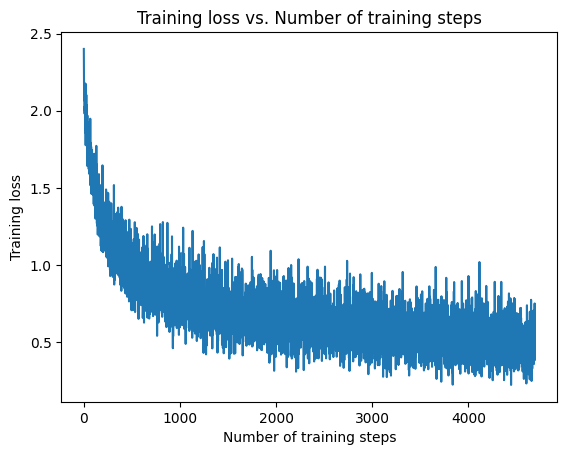

In [ ]:
print('accuracy=', accuracy)
plot_training_loss(lc, config)